Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 1  
Due: April 17, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib

from hw1 import *
import time

In [3]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
wd="/mnt/Backups/jmhu"

data_dir=wd+"/git_dirs/ComplexSystems_AMATH563/hw1/data/"
model_dir=wd+"/git_dirs/ComplexSystems_AMATH563/hw1/models/cross-validate_full/"
fig_dir = wd+"/git_dirs/ComplexSystems_AMATH563/hw1/figures/cross-validate_full/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

## Load data

In [4]:
with open(data_dir+"pickled_mnist.pkl", 'rb') as f:
    trainX, testX, trainY, testY = pickle.load(f)

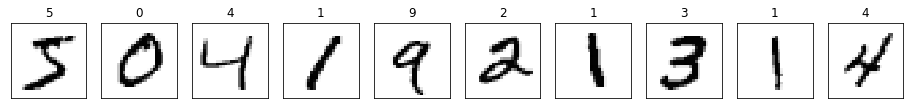

In [5]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY[i])

---

## Normalize data

In [6]:
print(trainX.min(), trainX.max())

scaler = StandardScaler()

trainX_norm = scaler.fit_transform(trainX)
testX_norm = scaler.transform(testX)

trainY = np.array(trainY)
testY = np.array(testY)

print(trainX_norm.min(), trainX_norm.max())

0 255
-1.2742078920822268 244.94693302873063


### Question 1.
Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

**Approach:** pick two solvers and vary regularization (guided by exploration runs)

In [7]:
solver_names = [
           "saga_elastic_L1_C01_mult", 
           "saga_elastic_L2_C01_mult",
           "saga_elastic_mix_C01_mult",
           "saga_elastic_half_C01_mult",
           "sgd_elastic_L2_C0005_mult"
          ]

In [8]:
%%time
n_jobs=4
tol=0.01

solvers=[]
l1_ratio = [1, 0, 0.8, 0.5]
multi_class="multinomial"

# saga + varying penalties
# with stochastic average gradient descent and L2 regularization

for i, model in enumerate(solver_names):
    if i+1 < (len(solver_names)):
        model=LogisticRegression(solver="saga", 
                                 multi_class=multi_class, 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=l1_ratio[i],
                                 n_jobs=n_jobs, 
                                 tol=tol)
    else:
        model=LogisticRegression(solver="sag", 
                                 multi_class=multi_class, 
                                 C=0.005, 
                                 penalty="l2", 
                                 n_jobs=n_jobs, 
                                 tol=tol)

    solvers.append(model)

CPU times: user 22 µs, sys: 11 µs, total: 33 µs
Wall time: 35 µs


In [9]:
solvers

[LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=1, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    warm_start=False),
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=0.8, max_iter=100,
                    multi_class='multinomial', n_jobs=4, penalty='elasticnet',
                    random_state=None, solver='saga', tol=0.01, verbose=0,
                    war

## Test times without cross-validation

In [10]:
cvs=[]

0
1022.00 sec elapsed
Cross-validation results: {'fit_time': array([165.9382019 , 163.92898226, 166.65434027, 163.472826  ,
       156.69023442]), 'score_time': array([0.02597308, 0.02332377, 0.0316155 , 0.02631307, 0.02626181]), 'test_score': array([0.91225   , 0.90716667, 0.90583333, 0.9045    , 0.91583333])}
saga_elastic_L1_C01_mult trained
Saving as hw1_cmsaga_elastic_L1_C01_mult.png
1
414.34 sec elapsed
Cross-validation results: {'fit_time': array([67.71893978, 72.67005587, 68.5092423 , 63.983356  , 56.82702351]), 'score_time': array([0.02531624, 0.0317986 , 0.02397227, 0.02758837, 0.02407432]), 'test_score': array([0.91308333, 0.908     , 0.907     , 0.90458333, 0.91725   ])}
saga_elastic_L2_C01_mult trained
Saving as hw1_cmsaga_elastic_L2_C01_mult.png
2
1061.92 sec elapsed
Cross-validation results: {'fit_time': array([173.39461565, 171.56303883, 169.94320726, 172.32266712,
       153.87856936]), 'score_time': array([0.02325392, 0.02340031, 0.02318001, 0.02779746, 0.02752638]), '

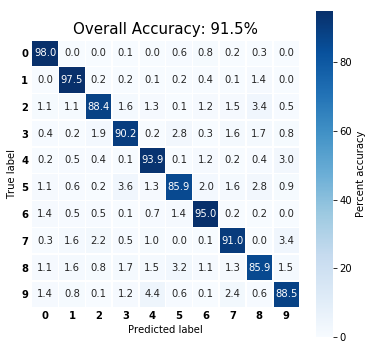

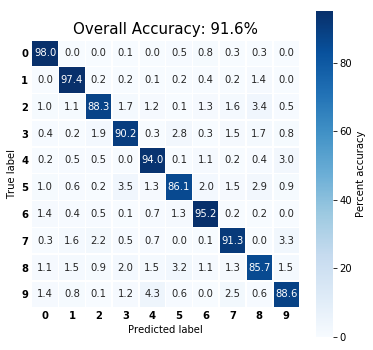

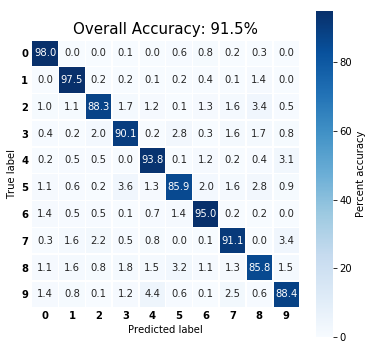

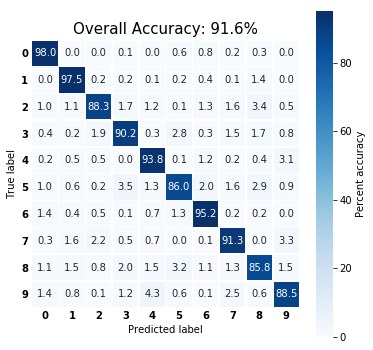

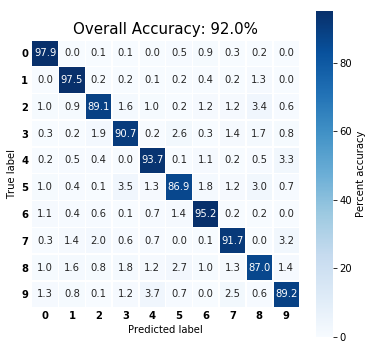

In [11]:
# A is the vectorized MNIST training images
A=trainX_norm.copy()

# B is the set of output vectors
B=trainY.copy()

models = []

# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    print(i)
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred = trained_model.predict(testX_norm)
        acc = trained_model.score(testX_norm, testY)
        
        print("Model exists and loaded")
        
    else:
        start=time.time()
        trained_model, pred, acc, cv = optimize(model, A, B, testX_norm, testY, cv=5)  
        print("{0:.2f}".format(time.time()-start), "sec elapsed")
        
        print("Cross-validation results:", cv)
        
        print(model_name, "trained")
        
        joblib.dump(trained_model, model_fn)

    models.append(trained_model)
    
    cvs.append(cv)
    
    r, m = compute_loss(trained_model, pred, testX_norm, testY)

    fig_name = fig_dir+"hw1_cm" + model_name + ".png"

    plot_confusion(m, acc, save_fn = fig_name)

In [12]:
# Check sparsity of solutions
sparsity_L1 = np.mean(models[0].coef_ == 0)*100
sparsity_L2 = np.mean(models[1].coef_ == 0)*100
sparsity_L1_mix = np.mean(models[2].coef_ == 0)*100
sparsity_L1_half = np.mean(models[3].coef_ == 0)*100
sparsity_sgd = np.mean(models[4].coef_ == 0)*100

print("Sparsity with L1 penalty:", "{0:.2f}".format(sparsity_L1), "%")
print("Sparsity with L2 penalty:", "{0:.2f}".format(sparsity_L2), "%")
print("Sparsity with 0.8 L1 ratio penalty:", "{0:.2f}".format(sparsity_L1_mix), "%")
print("Sparsity with 0.5 L1 ratio penalty:", "{0:.2f}".format(sparsity_L1_half), "%")
print("Sparsity with sgd L2 penalty:", "{0:.2f}".format(sparsity_sgd), "%")

Sparsity with L1 penalty: 24.11 %
Sparsity with L2 penalty: 8.55 %
Sparsity with 0.8 L1 ratio penalty: 22.96 %
Sparsity with 0.5 L1 ratio penalty: 19.11 %
Sparsity with sgd L2 penalty: 8.55 %


### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling. 

#### View model sparsity and digit importance with varying L1 penalty ratio (from 0 to 1) using multinomial logistic regression

In [13]:
m_index=2
thisModel = models[m_index]
coef=thisModel.coef_

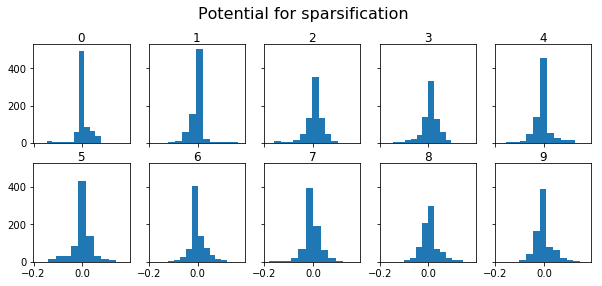

In [14]:
hist_coef(thisModel)

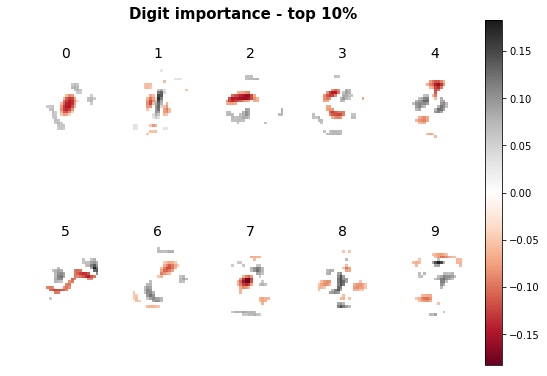

In [15]:
plot_vip(thisModel, p=5)

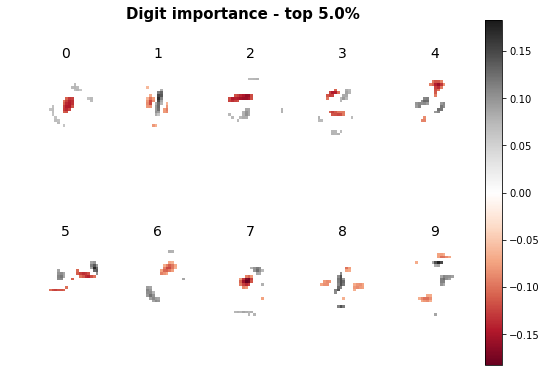

In [16]:
plot_vip(thisModel)

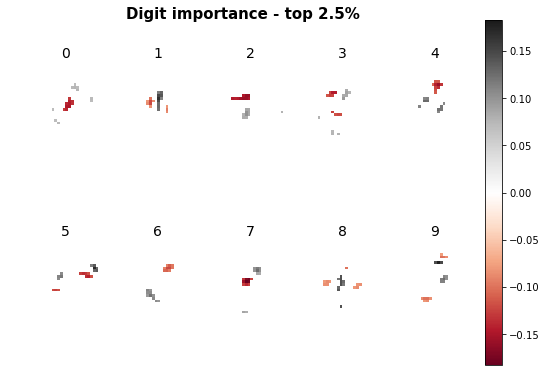

In [17]:
plot_vip(thisModel, p=1.25)

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

#### Rank pixels in single image to show most informative for digit labelling using LASSO

In [18]:
%%time

# Use non-normalized pixels for training
A = trainX.copy()
B = trainY.copy()

model=Lasso(tol=tol)
model_name="lasso"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc, cv = optimize(model, A, B, testX, testY, cv=5)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print("Cross-validation results:", cv)

cvs.append(cv)

joblib.dump(trained_model, model_fn)

19.69 sec elapsed
Cross-validation results: {'fit_time': array([2.99801016, 2.99955273, 3.07082272, 5.41062021, 3.28137732]), 'score_time': array([0.02117705, 0.02701688, 0.03258491, 0.01701689, 0.01857805]), 'test_score': array([0.60241081, 0.58661313, 0.600502  , 0.58327815, 0.61149321])}
CPU times: user 2min 28s, sys: 1min 57s, total: 4min 26s
Wall time: 19.7 s


In [19]:
trained_model

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

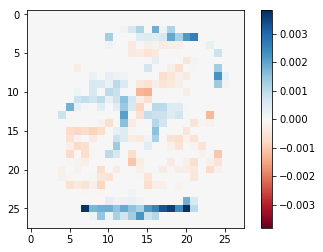

In [20]:
# Visualize important pixels using LASSO regression
A_lasso = trained_model.coef_.copy()

clim=max(np.abs(A_lasso.min()), np.abs(A_lasso.max()))
plt.imshow(A_lasso.reshape(28,28), vmin=-clim, vmax=clim, cmap="RdBu")
plt.colorbar()

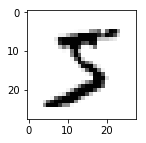

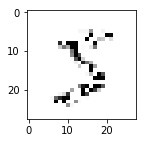

In [21]:
# Use A_lasso coefficients to mask training data
X=trainX.copy()

A_lasso_mask = A_lasso == 0

plt.figure(figsize=(2,2))
plt.imshow(X[0].reshape(28,28), plt.cm.Greys)
plt.figure(figsize=(2,2))
plt.imshow(np.ma.masked_where(A_lasso_mask, X[0]).reshape(28,28), plt.cm.Greys)

In [22]:
%%time
# extract new training dataset
new_X_byLASSO=np.empty_like(X)

for f in range(X.shape[0]):
    new_X_byLASSO[f, A_lasso_mask] = X[f,:][A_lasso_mask] 

CPU times: user 447 ms, sys: 34.8 ms, total: 482 ms
Wall time: 377 ms


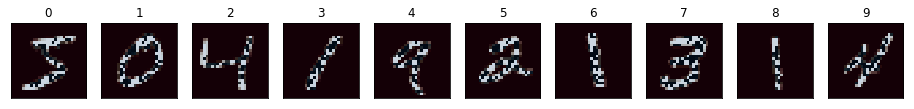

In [23]:
# Check out the new training set
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = new_X_byLASSO[i,:].reshape(28,28)
    img2 = X[i,:].reshape(28,28)    
    ax.imshow(img2, cmap="RdBu")
    ax.imshow(img, cmap="Greys_r", alpha=0.8)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

#### Use logistic regression model relying on non-zero LASSO coefficient pixels as mask for training data

1048.64 sec elapsed
Cross-validation results: {'fit_time': array([170.14102745, 172.81943107, 170.15686965, 171.77351379,
       164.89131665]), 'score_time': array([0.02685332, 0.03448057, 0.0371666 , 0.03004289, 0.03001475]), 'test_score': array([0.9075    , 0.90591667, 0.90266667, 0.89908333, 0.91233333])}
Saving as hw1_cmlasso_pick_saga_mix_C01_mult.png
CPU times: user 3min 24s, sys: 5 s, total: 3min 29s
Wall time: 17min 29s


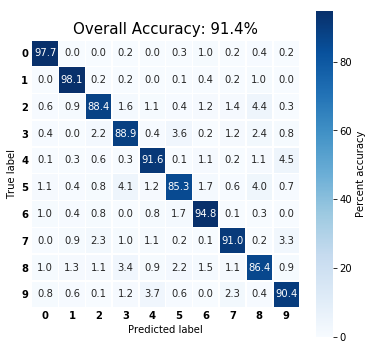

In [24]:
%%time

# Use important pixels as training matrix
A = new_X_byLASSO
B = trainY

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

model_name="lasso_pick_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc, cv = optimize(model, A, B, testX, testY, cv=5)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print("Cross-validation results:", cv)

cvs.append(cv)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir+"hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)
joblib.dump(trained_model, model_fn)

In [25]:
sparsity_LASSO_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with LASSO digit extraction and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_LASSO_mix), "%")

Sparsity with LASSO digit extraction and 0.8 L1 ratio penalty: 50.05 %


### Add normalization to the classification portion

915.52 sec elapsed
Cross-validation results: {'fit_time': array([148.27512598, 146.45351052, 146.05127311, 146.10512567,
       147.7788496 ]), 'score_time': array([0.02884007, 0.02322888, 0.02206326, 0.02480841, 0.01861835]), 'test_score': array([0.8905    , 0.8865    , 0.882     , 0.88      , 0.89833333])}
Saving as hw1_cmlasso_pick_normX_saga_mix_C01_mult.png
CPU times: user 3min 6s, sys: 5.42 s, total: 3min 12s
Wall time: 15min 16s


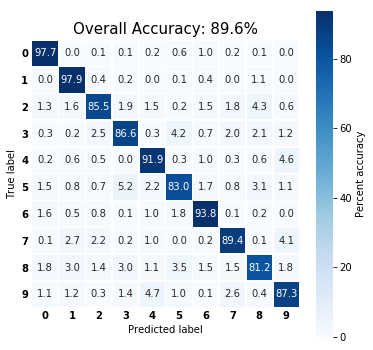

In [26]:
%%time

# extract new normalized training dataset
new_X_byLASSO=np.empty_like(trainX_norm)

for f in range(trainX_norm.shape[0]):
    new_X_byLASSO[f, A_lasso_mask] = trainX_norm[f,:][A_lasso_mask] 
    
# Use important pixels as training matrix
A = new_X_byLASSO
B = trainY

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

model_name="lasso_pick_normX_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

start=time.time()
trained_model, pred, acc, cv = optimize(model, A, B, testX_norm, testY, cv=5)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print("Cross-validation results:", cv)

cvs.append(cv)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir+"hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

joblib.dump(trained_model, model_fn)

In [27]:
sparsity_LASSO_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with LASSO digit extraction, normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_LASSO_mix), "%")

Sparsity with LASSO digit extraction, normalization and 0.8 L1 ratio penalty: 50.84 %


### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

#### Create training set for each digit using nonzero SAGA coefficients

0


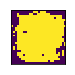

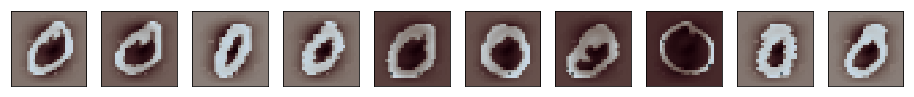

1


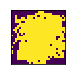

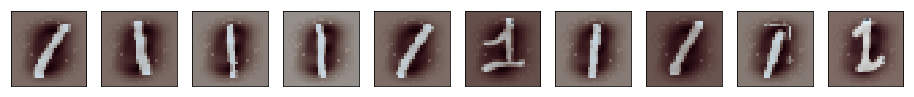

2


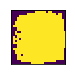

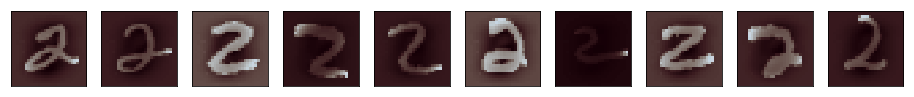

3


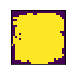

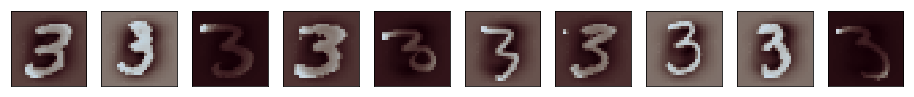

4


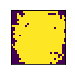

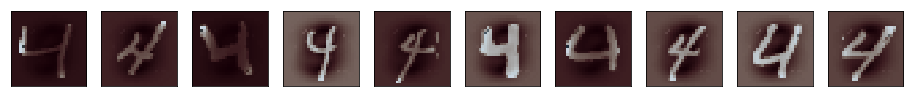

5


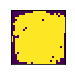

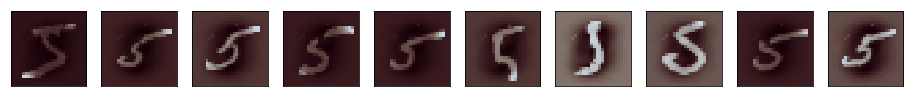

6


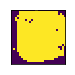

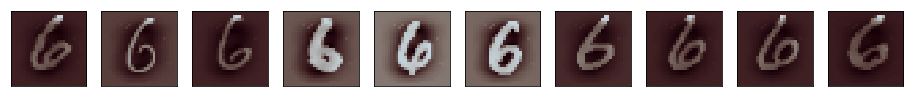

7


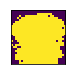

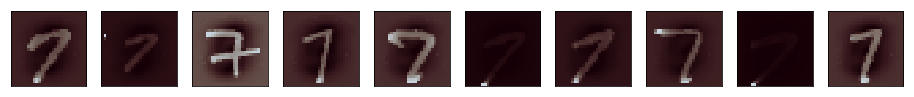

8


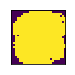

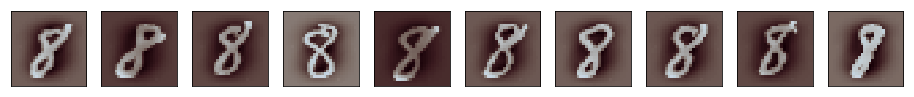

9


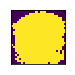

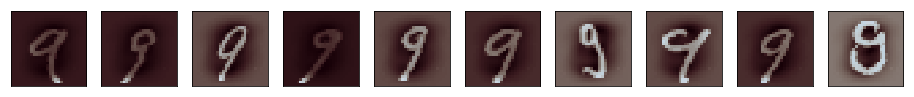

1893.17 sec elapsed
Cross-validation results: {'fit_time': array([304.65393853, 315.32027578, 300.31531143, 296.5302465 ,
       291.70986795]), 'score_time': array([0.02665663, 0.02619553, 0.03271151, 0.02521849, 0.03278852]), 'test_score': array([0.92083333, 0.91658333, 0.91433333, 0.91308333, 0.92475   ])}
lasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult.png


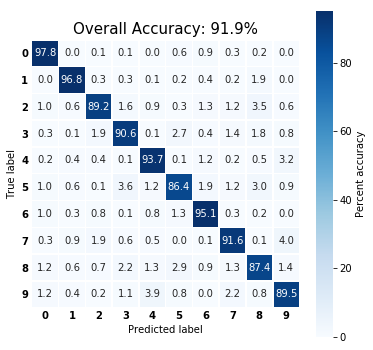

In [28]:
coef=thisModel.coef_

indices=[]

testX_digits=testX_norm.copy()
trainX_digits=trainX_norm.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] == 0)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure(figsize=(1,1))
    plt.imshow(test_img.reshape(28,28))    
    plt.xticks(())
    plt.yticks(())
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_normX_vip_digit_nonzero_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX_norm)
    acc = trained_model.score(testX_norm, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc, cv = optimize(model, A, B, testX_norm, testY, cv=5)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")
    
    print("Cross-validation results:", cv)
    
    print(model_name, "trained")

    cvs.append(cv)
    
    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [29]:
sparsity_digits_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction (all nonzero) and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_digits_mix), "%")

Sparsity with individual digit extraction (all nonzero) and 0.8 L1 ratio penalty: 21.59 %


## without normalization

0


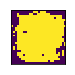

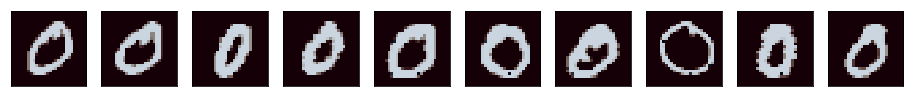

1


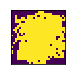

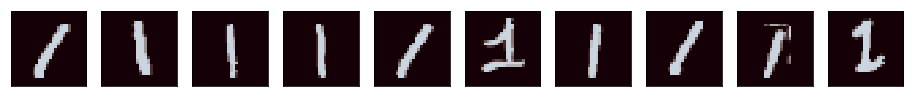

2


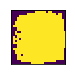

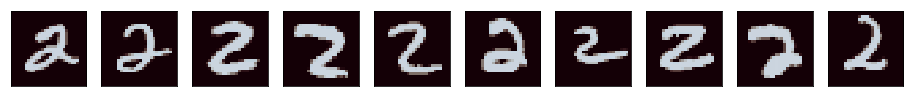

3


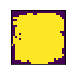

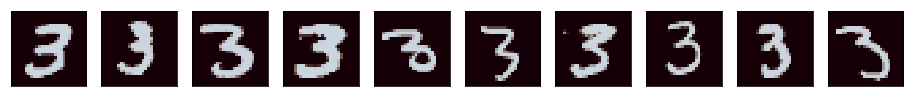

4


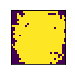

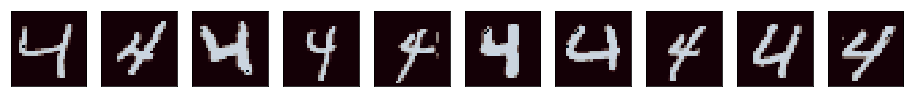

5


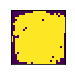

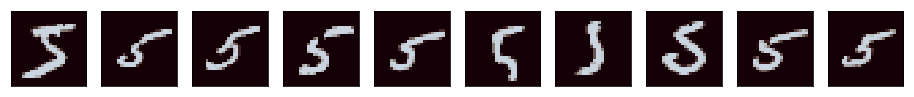

6


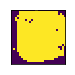

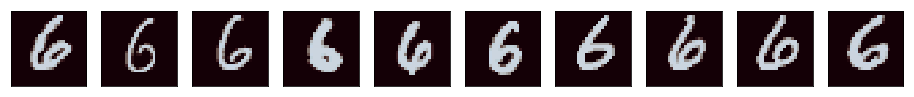

7


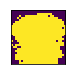

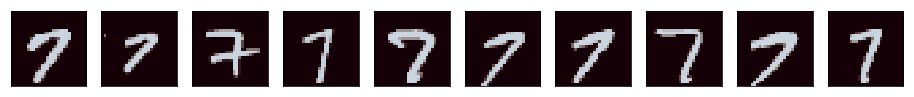

8


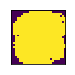

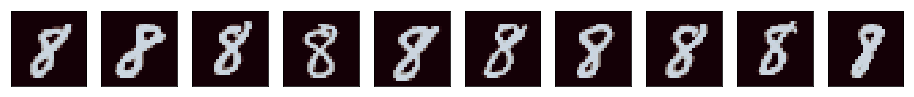

9


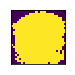

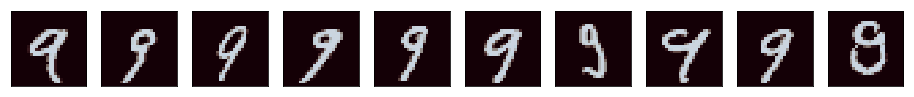

915.12 sec elapsed
Cross-validation results: {'fit_time': array([144.88553572, 146.30120444, 147.34509397, 148.34294415,
       147.97187948]), 'score_time': array([0.03378344, 0.0320766 , 0.0236361 , 0.03163052, 0.03073645]), 'test_score': array([0.94075   , 0.93508333, 0.93433333, 0.93391667, 0.94175   ])}
lasso_pick_vip_digit_nonzero_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_nonzero_saga_mix_C01_mult.png


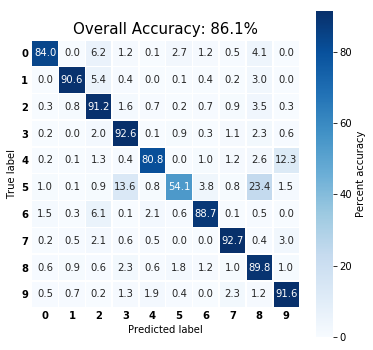

In [30]:
coef=models[2].coef_

indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] == 0)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure(figsize=(1,1))
    plt.imshow(test_img.reshape(28,28))    
    plt.xticks(())
    plt.yticks(())
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_nonzero_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX)
    acc = trained_model.score(testX, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc, cv = optimize(model, A, B, testX, testY, cv=5)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")

    print("Cross-validation results:", cv)
    
    print(model_name, "trained")

    cvs.append(cv)
    
    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [31]:
sparsity_digits_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction (all nonzero), normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_digits_mix), "%")

Sparsity with individual digit extraction (all nonzero), normalization and 0.8 L1 ratio penalty: 20.57 %


#### Using 10% of coefficients

0


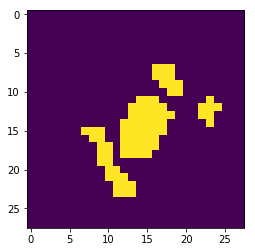

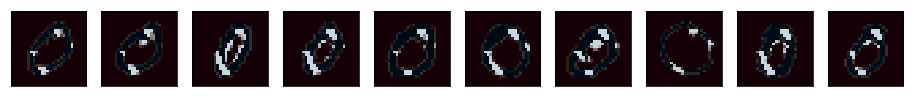

1


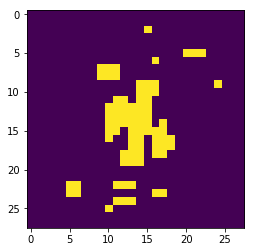

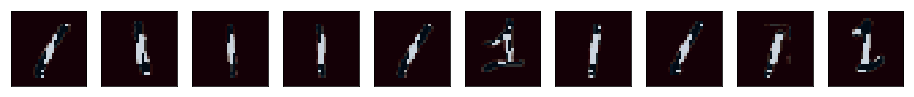

2


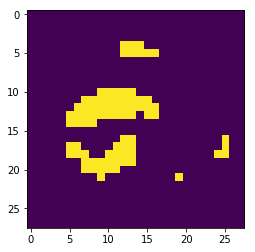

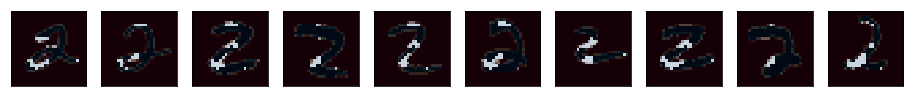

3


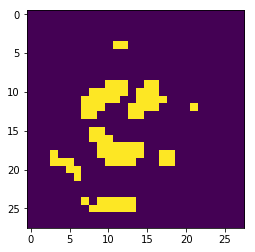

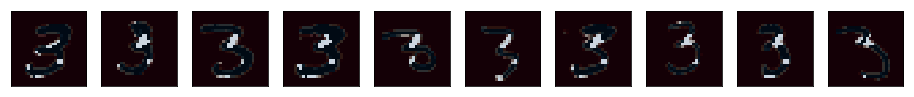

4


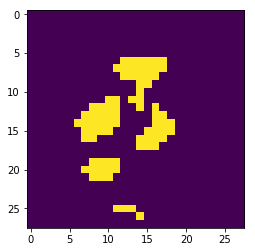

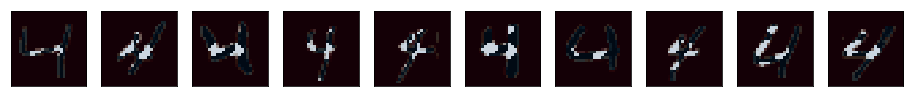

5


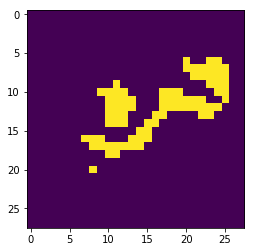

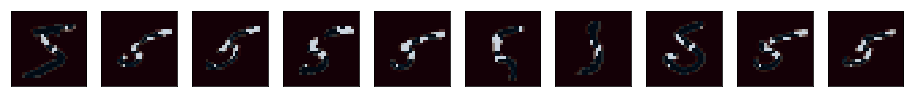

6


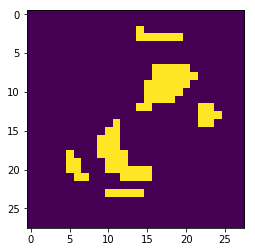

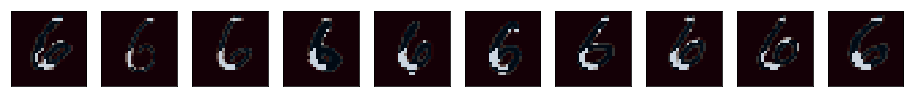

7


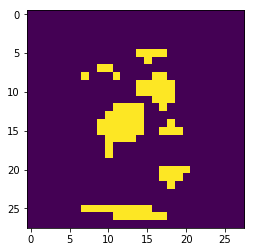

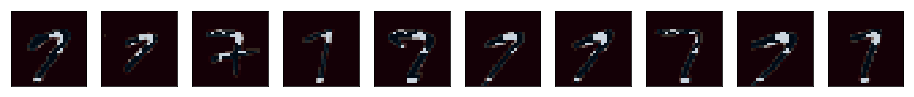

8


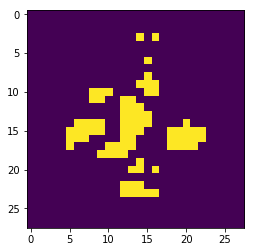

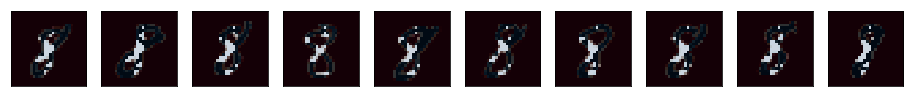

9


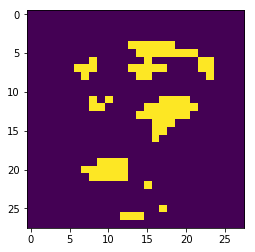

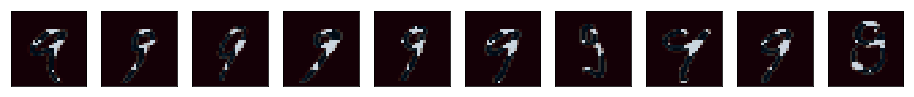

419.27 sec elapsed
Cross-validation results: {'fit_time': array([71.31310272, 50.44565105, 71.5544467 , 77.02516723, 68.81959915]), 'score_time': array([0.03368163, 0.03148723, 0.03254056, 0.03262424, 0.03095984]), 'test_score': array([1.        , 0.99991667, 0.99983333, 1.        , 0.99991667])}
lasso_pick_vip_digit_10perc_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_10perc_saga_mix_C01_mult.png


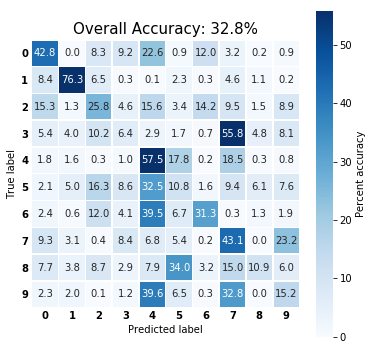

In [32]:
coef=models[2].coef_

p=5
indices=[]

testX_digits=testX.copy()
trainX_digits=trainX.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_"+str(2*p)+"perc_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

start=time.time()
trained_model, pred, acc, cv = optimize(model, A, B, testX, testY, cv=5)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print("Cross-validation results:", cv)

cvs.append(cv)

print(model_name, "trained")

joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [33]:
sparsity_vip_digits_10percent_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction, top 10% of coefficients and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_vip_digits_10percent_mix), "%")

Sparsity with individual digit extraction, top 10% of coefficients and 0.8 L1 ratio penalty: 63.92 %


### With normalization

0


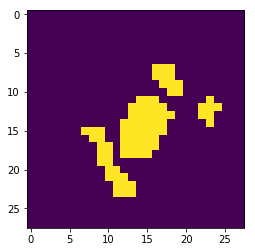

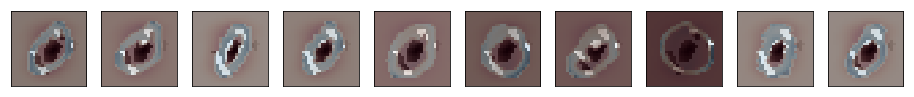

1


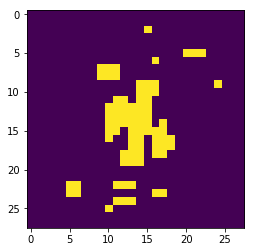

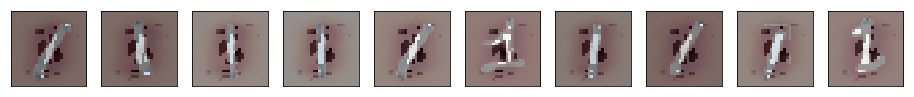

2


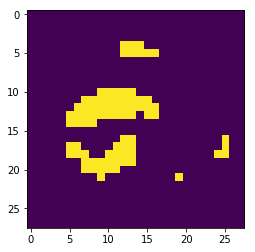

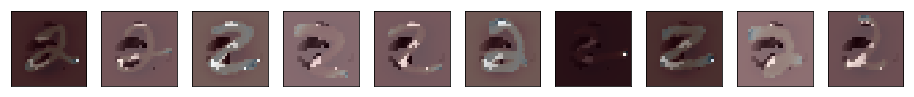

3


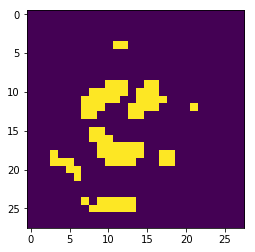

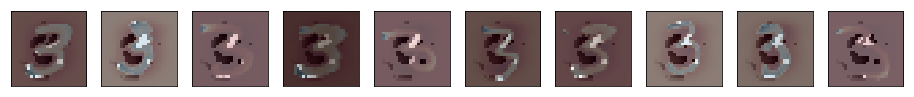

4


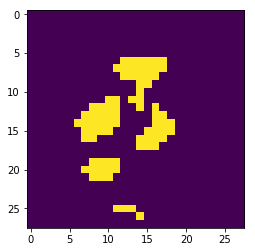

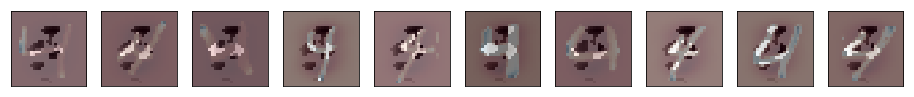

5


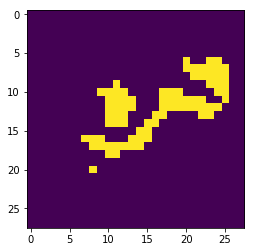

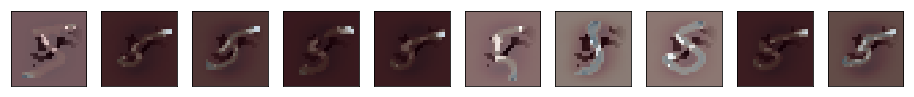

6


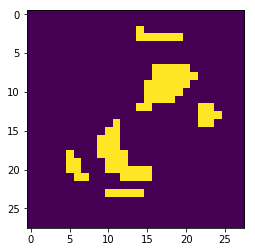

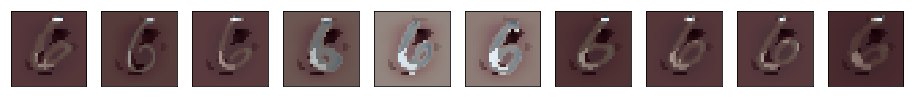

7


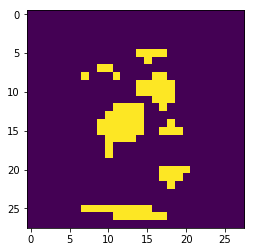

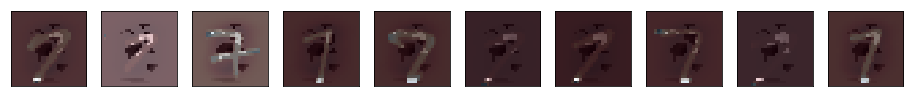

8


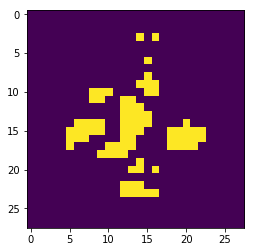

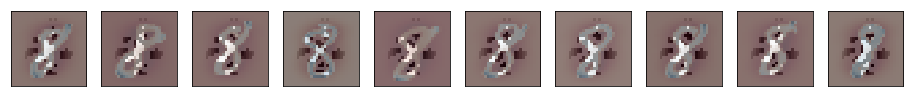

9


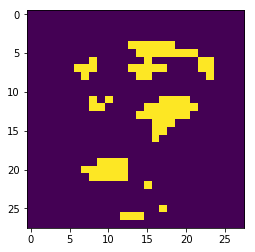

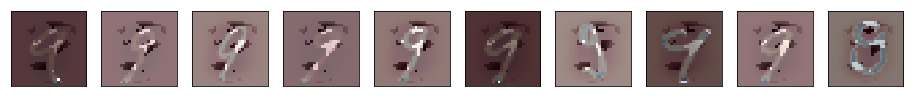

636.92 sec elapsed
Cross-validation results: {'fit_time': array([ 94.18564653, 110.45637798, 103.09677958, 100.63938618,
       103.33065844]), 'score_time': array([0.02743411, 0.02314138, 0.02484488, 0.02473807, 0.02248311]), 'test_score': array([0.9875    , 0.98616667, 0.98775   , 0.98425   , 0.9855    ])}
lasso_pick_vip_digit_10perc_saga_mix_C01_mult trained
Saving as hw1_cmlasso_pick_vip_digit_10perc_saga_mix_C01_mult.png


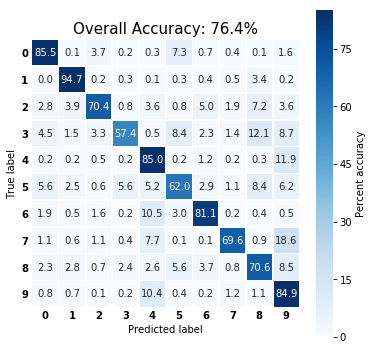

In [34]:
coef=models[2].coef_

p=5
indices=[]

testX_digits=testX_norm.copy()
trainX_digits=trainX_norm.copy()

new_trainX_digits=np.empty_like(trainX_digits)

for digit in range(10):
    print(digit)
    cmin, cmax = (np.percentile(coef[digit],p), np.percentile(coef[digit],100-p))
    inds=np.indices(coef[digit].shape).squeeze()

    # Extract indices from thresholded model coefficients
    inds[(coef[digit] > cmin) & (coef[digit] < cmax)] = 9999
    inds=inds[inds!=9999]
    
    # temp storage for double checks
    indices.append(inds)
    
    # blank image
    test_img=np.zeros_like(coef[digit])
    test_img[inds] = 255

    # important pixels for this digit
    plt.figure()
    plt.imshow(test_img.reshape(28,28))    
    
    # Use indices to extract new training and test X dataset
    # For only the training images that are labeled 0
    trainX_digit=trainX_digits[trainY==digit,:]
    new_trainX_digit=np.apply_along_axis(fandr, indices=inds, axis=1, arr=trainX_digit)
    new_trainX_digits[trainY==digit,:]=new_trainX_digit

    # Check out some digits
    plt.figure(figsize=(16,4))

    for j in range(10):
        ax = plt.subplot(1, 10, j + 1)
        img = trainX_digit[j].reshape((28,28))
        img2 = new_trainX_digit[j].reshape((28,28))
        ax.imshow(img, cmap="RdBu")
        ax.imshow(img2, cmap="Greys_r", alpha=0.8)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

# Use nonzero pixels as training matrix
A = new_trainX_digits
B = trainY.copy()

model_name="lasso_pick_vip_digit_"+str(2*p)+"perc_saga_mix_C01_mult"
model_fn=model_dir + model_name + ".pkl"

model=LogisticRegression(
    C=0.1, 
    l1_ratio=0.8,
    n_jobs=n_jobs,
    penalty="elasticnet",
    solver='saga',
    tol=tol)

start=time.time()
trained_model, pred, acc, cv = optimize(model, A, B, testX_norm, testY, cv=5)  
print("{0:.2f}".format(time.time()-start), "sec elapsed")

print("Cross-validation results:", cv)

cvs.append(cv)

print(model_name, "trained")

joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [35]:
sparsity_vip_digits_10percent_mix = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with individual digit extraction, top 10% of coefficients, normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_vip_digits_10percent_mix), "%")

Sparsity with individual digit extraction, top 10% of coefficients, normalization and 0.8 L1 ratio penalty: 88.71 %


## BONUS

#### Do this with one-vs-rest appropach

341.45 sec elapsed
Cross-validation results: {'fit_time': array([55.33840919, 54.24375558, 55.0248425 , 54.9604764 , 51.64613295]), 'score_time': array([0.03042054, 0.03078699, 0.03275442, 0.02272224, 0.03460407]), 'test_score': array([0.88616667, 0.87866667, 0.87558333, 0.87725   , 0.89325   ])}
saga_elastic_mix_C01_ovr trained
Saving as hw1_cmsaga_elastic_mix_C01_ovr.png


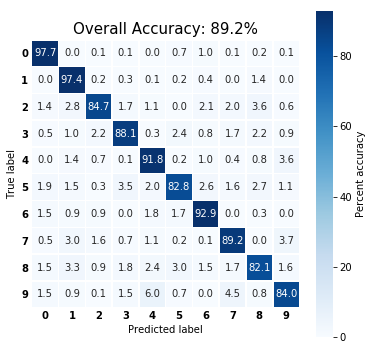

In [36]:
A = trainX_norm
B = trainY

model=LogisticRegression(solver="saga", 
                                 multi_class='ovr', 
                                 C=0.1, 
                                 penalty="elasticnet", 
                                 l1_ratio=0.8,
                                 n_jobs=n_jobs, 
                                 tol=tol)
model_name="saga_elastic_mix_C01_ovr"

model_fn=model_dir + model_name + ".pkl"

if os.path.exists(model_fn):
    trained_model = joblib.load(model_fn)
    pred = trained_model.predict(testX_norm)
    acc = trained_model.score(testX_norm, testY)

    print("Model exists and loaded")

else:
    start=time.time()
    trained_model, pred, acc, cv = optimize(model, A, B, testX_norm, testY, cv=5)  
    print("{0:.2f}".format(time.time()-start), "sec elapsed")
    
    print("Cross-validation results:", cv)
    
    cvs.append(cv)
    
    print(model_name, "trained")

    joblib.dump(trained_model, model_fn)

r, m = compute_loss(trained_model, pred, testX_norm, testY)
fig_name = fig_dir + "hw1_cm" + model_name + ".png"
plot_confusion(m, acc, save_fn = fig_name)

In [37]:
sparsity_ovr = np.mean(trained_model.coef_ == 0)*100
print("Sparsity with ovr normalization and 0.8 L1 ratio penalty:", 
      "{0:.2f}".format(sparsity_ovr), "%")

Sparsity with ovr normalization and 0.8 L1 ratio penalty: 15.27 %


In [73]:
clim=np.maximum(np.abs(models[2].coef_).max(), np.abs(trained_model.coef_).max())
clim

0.20927043302429055

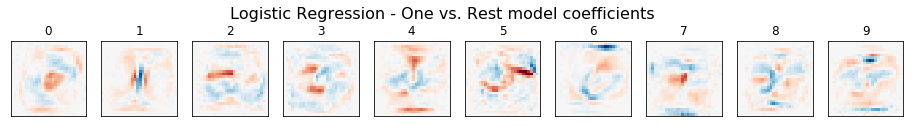

In [74]:
# Check out ovr digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trained_model.coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu", vmin=-clim, vmax=clim)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - One vs. Rest model coefficients", fontsize=16, y=0.75);

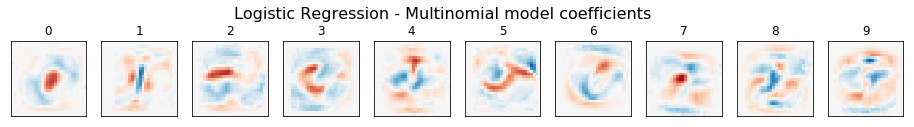

In [75]:
# Check out multinomial digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = models[2].coef_[i].reshape((28,28))
    ax.imshow(img, cmap="RdBu", vmin=-clim, vmax=clim)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(i)
plt.suptitle("Logistic Regression - Multinomial model coefficients", fontsize=16, y=0.75);

### check mean and std of test_scores for cross-validation results

In [45]:
test_scores=[cv['test_score'] for cv in cvs]

In [53]:
print(np.expand_dims(np.mean(np.array(test_scores), axis=1), axis=1))

[[0.90911667]
 [0.90998333]
 [0.90931667]
 [0.90963333]
 [0.9139    ]
 [0.59685946]
 [0.9055    ]
 [0.88746667]
 [0.91791667]
 [0.93716667]
 [0.99993333]
 [0.98623333]
 [0.88218333]]


In [54]:
print(np.expand_dims(np.std(np.array(test_scores), axis=1), axis=1))

[[4.26210694e-03]
 [4.56964623e-03]
 [4.17246264e-03]
 [4.41103414e-03]
 [4.69674828e-03]
 [1.04658634e-02]
 [4.47368851e-03]
 [6.53996262e-03]
 [4.31695623e-03]
 [3.36980052e-03]
 [6.23609564e-05]
 [1.29464710e-03]
 [6.61215211e-03]]
